In [5]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import ensemble

Učitavanje podataka i preprocesiranje su isti kao i u prethodnoj datoteci.

In [6]:
data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1')

In [7]:
data = data.rename(columns={'0':'Sentiment',
                     '1467810369': 'Tweet ID',
                     'Mon Apr 06 22:19:45 PDT 2009':'Date',
                     'NO_QUERY':'Query',
                     '_TheSpecialOne_':'Username',
                     "@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D":'Tweet'})

In [8]:
def Sentiment_remap(x):
    if x == 0:
        return 0
    else:
        return 1

In [9]:
data['Sentiment'] = data['Sentiment'].apply(Sentiment_remap)

In [10]:
def username_removal(string):
    
    for i in range(string.count('@')): 
        username_begin_index = string.find('@')
        username_end_index = string[username_begin_index::].find(' ') + username_begin_index
    
        string = string.replace(string[username_begin_index:username_end_index+1],' ')
    
    return string                    

In [11]:
data['Tweet'] = data['Tweet'].apply(username_removal)

In [12]:
x = data['Tweet']
y = data['Sentiment']

In [13]:
tweet_count_vectorizer = CountVectorizer()

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.01, test_size=0.01, stratify=y, random_state=7)

In [15]:
tweet_count_vectorizer.fit(x_train)

CountVectorizer()

In [16]:
x_train_vectorized = tweet_count_vectorizer.transform(x_train)
x_test_vectorized = tweet_count_vectorizer.transform(x_test)

# MODEL 1 - Slučajne šume



Upoređuju se tačnosti šest modela slušajnih šuma različitih vrednosti maksimalne dubine listova. Svaki model sačinjava dvadeset stabala i iterativno se povećava, korakom od četiri, vrednost dubine listova. Razlog što maksimalna dubina ide do dvadeset četiri je ta što se brzina konstruisanja modela znatno povećava posle toga. Ista stvar važi i za konstantnu vrednost broja stabala u modelima.

In [28]:
accs1 = []
for i in range(4,25, 4):

    model1 = ensemble.RandomForestClassifier(n_estimators=20, max_depth=i, random_state=7)
    model1.fit(x_train_vectorized, y_train)
    y_predicted1 = model1.predict(x_test_vectorized)
    accs1.append(accuracy_score(y_test, y_predicted1))
    

Sa slike se može uočiti da tačnost raste sa povećanjem maksimalne dubine listova. Međutim, porast se smanjuje što ka svakom sledećem modelu. 

<BarContainer object of 6 artists>

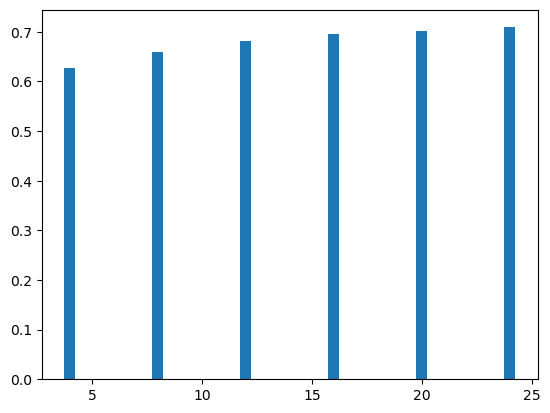

In [29]:
plt.bar(range(4, 25, 4), accs1, width=0.5)

In [30]:
print(classification_report(y_test, y_predicted1))

              precision    recall  f1-score   support

           0       0.72      0.68      0.70      8000
           1       0.70      0.74      0.72      8000

    accuracy                           0.71     16000
   macro avg       0.71      0.71      0.71     16000
weighted avg       0.71      0.71      0.71     16000



Tačnost su propratile i ostale evaluacione mere koje su imale slične vrednosti. 


# MODEL 2 - Prosta agregacija



Sličan stvar se radi i za prostu agregaciju. Kod nje je postavljeno i veći broj stabala zbog loših rezultata koje je pokazalo sa malim vrednostima. Sve vrednosti koje su kontantne su postavljene na svoju maksimalnu vrednost da bi modeli mogli da se kreiraju u prihvatljivom vremenu.

In [18]:
accs2 = []
for i in range(4,25, 4):
    model2 = ensemble.BaggingClassifier(tree.DecisionTreeClassifier(max_depth=10 ,random_state=42), n_estimators=i*3, max_samples=i, bootstrap=True, random_state=7)
    model2.fit(x_train_vectorized, y_train)
    y_predicted2 = model2.predict(x_test_vectorized)
    accs2.append(accuracy_score(y_test, y_predicted2))


<BarContainer object of 6 artists>

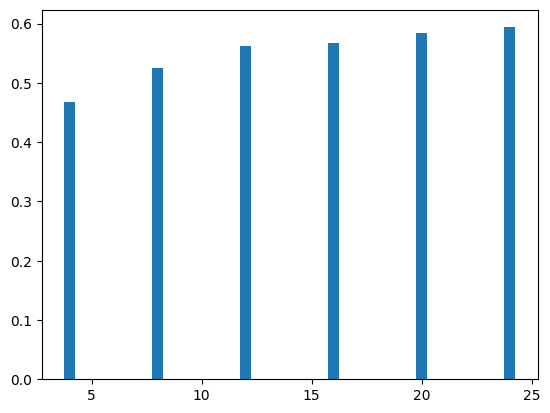

In [19]:
plt.bar(range(4, 25, 4), accs2, width=0.5)

In [20]:
print(classification_report(y_test, y_predicted2))

              precision    recall  f1-score   support

           0       0.60      0.55      0.58      8000
           1       0.59      0.64      0.61      8000

    accuracy                           0.59     16000
   macro avg       0.59      0.59      0.59     16000
weighted avg       0.59      0.59      0.59     16000



Razlog zašto ovakav model radi lošije od običnih slučajnih šuma je baš taj što se oslanja na greške prethodnih modela. Forma modela slučajnih šuma nije adekvatna za rad sa ovakvim skupom podataka jer ne obuhvata smisao rečenica, a pokušaj da se iskoristi takav model i iz njega izvuče korisna informacija dovodi do još gorih rezultata.

# MODEL 3 - Pojačavanje (XG Boost)



Kao i u prethodim primerima, maksimalna dubina će se varirati i u pojačanju gradijentnim spustom.

In [21]:
import xgboost

In [24]:
accs3 = []
for i in range(4,25, 4):
    model3= xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=10, max_depth=i)
    model3.fit(x_train_vectorized, y_train)
    y_predicted3 = model3.predict(x_test_vectorized)
    accs3.append(model3.score(x_test_vectorized, y_test))

In [25]:
from sklearn import metrics
metrics.mean_squared_error(y_test, y_predicted3)

0.19783300712377042

<BarContainer object of 6 artists>

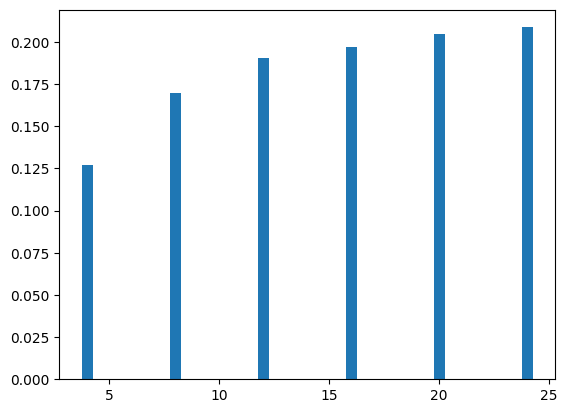

In [27]:
plt.bar(range(4, 25, 4), accs3, width=0.5)

Ovi rezultati su neočekivani jer se proširivanjem slabala povećava srednjekvadratna greška. Ono što se može zaklučiti da gradijentni spust definitivno ima kontra efekat na klasifikaciju ovakvog skupa podataka.